# Fine tune with Efficientnet

In [1]:
!pip install keras-cv==0.4.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 634.9/634.9 kB 10.0 MB/s eta 0:00:00


In [2]:
import os, pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
from datetime import datetime
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pydantic import BaseModel as ConfigBaseModel
import tensorflow as tf
print("tensorflow:", tf.__version__)
import keras_cv
print("keras_cv:", keras_cv.__version__)
import tensorflow_io as tfio
print("tfio:", tfio.__version__)
from sklearn.model_selection import train_test_split

tensorflow: 2.11.0
You do not have pycocotools installed, so KerasCV pycoco metrics are not available. Please run `pip install pycocotools`.
You do not have pyococotools installed, so the `PyCOCOCallback` API is not available.
You do not have Waymo Open Dataset installed, so KerasCV Waymo metrics are not available.
keras_cv: 0.4.2
tfio: 0.29.0


In [3]:
strategy = tf.distribute.MirroredStrategy()
print("Strategy:", strategy)
print("Number of replicas:", strategy.num_replicas_in_sync)

Strategy: <tensorflow.python.distribute.mirrored_strategy.MirroredStrategy object at 0x7a7fe0977210>
Number of replicas: 1


In [4]:
sorted(tf.config.list_logical_devices())

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

# Config

In [5]:
class Config(ConfigBaseModel):
    ## general
    run_ts = datetime.now().strftime("%Y-%d-%m %H:%M:%S")
    debug = False
    model_name = "transfer_learn_simple"
    test_size = 0.2
    seed = 887
    fit_verbose = 1 if (os.environ.get('KAGGLE_KERNEL_RUN_TYPE') == "Interactive") else 2
    ## data
    dataset_dir = "/kaggle/input/data-pipeline-with-upsampled-128-x-256/train/"
    path_data = "/kaggle/input/data-pipeline-with-upsampled-128-x-256/img_stats_with_upsample.csv"
    label = "label"
    n_label = 264
    img_size = (128, 256)
    channels = 1
    img_shape = (*img_size, channels)
    ## model
    base_model_weights = "imagenet"
    dropout = 0.20
    ## training
    label_smoothing = 0.05
    shuffle_size = 1028
    steps_per_epoch = 300
    batch_size = 128  # 16 * strategy.num_replicas_in_sync
    valid_batch_size = batch_size
    epochs = 80
    patience = 4
    monitor = "val_loss"  # val_loss
    monitor_mode = "auto"
    lr = 1e-4
    ## aug
    aug_proba = 0.8
    
    
    
cfg = Config()
with open("cfg.json", "w") as f:
    f.write(cfg.json(indent=2))
cfg.dict()    

{'run_ts': '2023-11-05 17:39:15',
 'debug': False,
 'model_name': 'transfer_learn_simple',
 'test_size': 0.2,
 'seed': 887,
 'fit_verbose': 2,
 'dataset_dir': '/kaggle/input/data-pipeline-with-upsampled-128-x-256/train/',
 'path_data': '/kaggle/input/data-pipeline-with-upsampled-128-x-256/img_stats_with_upsample.csv',
 'label': 'label',
 'n_label': 264,
 'img_size': (128, 256),
 'channels': 1,
 'img_shape': (128, 256, 1),
 'base_model_weights': 'imagenet',
 'dropout': 0.2,
 'label_smoothing': 0.05,
 'shuffle_size': 1028,
 'steps_per_epoch': 300,
 'batch_size': 128,
 'valid_batch_size': 128,
 'epochs': 80,
 'patience': 4,
 'monitor': 'val_loss',
 'monitor_mode': 'auto',
 'lr': 0.0001,
 'aug_proba': 0.8}

# Preparation

## Load data

In [6]:
data = pd.read_csv(cfg.path_data)
data["path_img"] = cfg.dataset_dir + data["filename"]
if cfg.debug:
    data = data.iloc[:1000]
data

,label,orig_filename,offset,ret,filename,path_img
0,0,abethr1/XC128013.ogg,0,True,abethr1/XC128013_0.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...
1,0,abethr1/XC128013.ogg,1,True,abethr1/XC128013_1.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...
2,0,abethr1/XC128013.ogg,2,True,abethr1/XC128013_2.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...
3,0,abethr1/XC128013.ogg,3,True,abethr1/XC128013_3.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...
4,0,abethr1/XC128013.ogg,4,True,abethr1/XC128013_4.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...
...,...,...,...,...,...,...
128510,11,afpkin1/XC704863.ogg,95,True,afpkin1/XC704863_95.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...
128511,11,afpkin1/XC704863.ogg,96,True,afpkin1/XC704863_96.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...
128512,11,afpkin1/XC704863.ogg,97,True,afpkin1/XC704863_97.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...
128513,11,afpkin1/XC704863.ogg,98,True,afpkin1/XC704863_98.jpeg,/kaggle/input/data-pipeline-with-upsampled-128...


## Dataset

In [7]:
AUTOTUNE = tf.data.AUTOTUNE


def show_img_stats(img):
    if isinstance(img, tf.Tensor):
        print((img.shape, img.dtype, img.numpy().min(), img.numpy().max()))
    elif isinstance(img, np.array):
        print((img.shape, img.dtype, img.min(), img.max()))
    else:
        print(f"unexpected type: {type(img)}")


def read_image(path_img):
    img_data = tf.io.read_file(path_img)
    img = tf.io.decode_jpeg(img_data, channels=cfg.channels)
    img = tf.reshape(img, cfg.img_shape)
    img = tf.cast(img, tf.float32)
    return img


def decode_label(label):
    return tf.one_hot(label, depth=cfg.n_label)

In [8]:
class RandomRowMask(keras_cv.layers.BaseImageAugmentationLayer):
    def __init__(self, param=10, num_mask=1, **kwargs):
        super().__init__(**kwargs)
        self.param = param
        self.num_mask = num_mask

    def augment_image(self, image, transformation=None, **kwargs):
        image_shape = tf.shape(image)
        num = self._random_generator.random_uniform((), 1, self.num_mask, dtype=tf.int32)
        for _ in tf.range(num):
            image = tfio.audio.time_mask(tf.squeeze(image), param=self.param)
            image = tf.reshape(image, shape=image_shape)
        return image
    
    
class RandomColumnMask(keras_cv.layers.BaseImageAugmentationLayer):
    def __init__(self, param=10, num_mask=1, **kwargs):
        super().__init__(**kwargs)
        self.param = param
        self.num_mask = num_mask

    def augment_image(self, image, transformation=None, **kwargs):
        image_shape = tf.shape(image)
        num = self._random_generator.random_uniform((), 1, self.num_mask, dtype=tf.int32)
        for _ in tf.range(num):        
            image = tfio.audio.freq_mask(tf.squeeze(image), param=self.param)
            image = tf.reshape(image, shape=image_shape)
        return image
    



augmenter = keras_cv.layers.Augmenter(
    layers=[
        keras_cv.layers.RandomBrightness(factor=0.2),
        keras_cv.layers.RandomContrast(factor=0.2),
        keras_cv.layers.GridMask(ratio_factor=(0.05, 0.10)),
        keras_cv.layers.RandomGaussianBlur(kernel_size=2, factor=0.1),
        RandomRowMask(10, 3),
        RandomColumnMask(40, 2)
    ]
)

def augment_image(img):
    if tf.random.uniform([]) <= cfg.aug_proba:
        img = augmenter(img)
    return img

In [9]:
def create_dataset(data, include_label=True, repeat=False, shuffle=False, augment=False, prefetch=False, batch_size=None):
    slices = data["path_img"].values
    read_func = read_image
    aug_func = augment_image
    if include_label:
        slices = slices, decode_label(data[cfg.label].values)
        read_func = lambda path_img, label: (read_image(path_img), label)
        aug_func = lambda img, label: (augment_image(img), label)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(read_func, num_parallel_calls=AUTOTUNE)
    if repeat: ds = ds.repeat()
    if shuffle: ds = ds.shuffle(buffer_size=cfg.shuffle_size)
    if augment: ds = ds.map(aug_func, num_parallel_calls=AUTOTUNE)
    if batch_size: ds = ds.batch(batch_size)
    if prefetch: ds = ds.prefetch(AUTOTUNE)
    return ds

In [10]:
def create_training_dataset(data):
    return create_dataset(
        data,
        include_label=True,
        repeat=True,
        shuffle=True,
        augment=True,
        prefetch=True,
        batch_size=cfg.batch_size,
    )


def create_validation_dataset(data):
    return create_dataset(
        data,
        include_label=True,
        repeat=False,
        shuffle=False,
        augment=False,
        prefetch=True,
        batch_size=cfg.valid_batch_size,
    )

#### Check augmentation

In [11]:
rec = data.sample(1).iloc[0]
rec

label                                                          126
orig_filename                                 joygre1/XC555858.ogg
offset                                                          16
ret                                                           True
filename                                  joygre1/XC555858_16.jpeg
path_img         /kaggle/input/data-pipeline-with-upsampled-128...
Name: 67444, dtype: object

(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 195.85156)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 251.29591)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 216.76982)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 206.18658)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 238.05066)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 219.46483)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 220.3207)


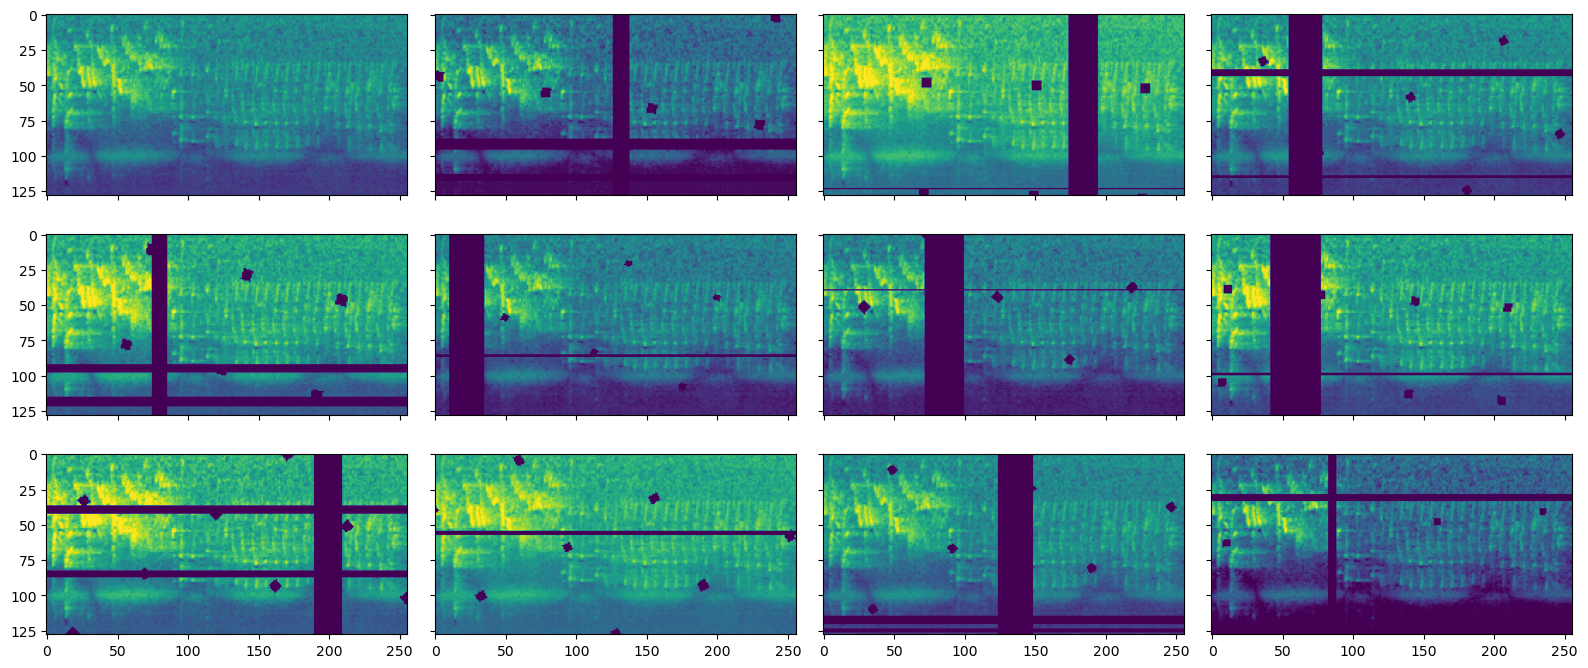

In [12]:
img = read_image(rec.path_img)
fig, axs = plt.subplots(3, 4, sharex='all', sharey='all', figsize=(16, 7))
for i, ax in enumerate(axs.flat):
    if i == 0:
        ax.imshow(img, cmap='viridis')
        show_img_stats(img)
    else:
        img1 = augmenter(img, training=True)
        ax.imshow(img1, cmap='viridis')
        show_img_stats(img1)
plt.tight_layout()
plt.show()   

#### Check dataset

In [13]:
dev_data = data.sample(500)
dev_ds = create_training_dataset(dev_data)
dev_ds

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 256, 1), dtype=tf.float32, name=None), TensorSpec(shape=(None, 264), dtype=tf.float32, name=None))>

In [14]:
elem = next(iter(dev_ds.take(1)))
elem[1]

<tf.Tensor: shape=(128, 264), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>

(TensorShape([128, 256, 1]), tf.float32, 0.0, 234.55588)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 188.33203)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 236.73425)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 201.9868)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 223.25256)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 236.76263)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 253.88132)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 255.0)
(TensorShape([128, 256, 1]), tf.float32, 0.0, 177.02866)


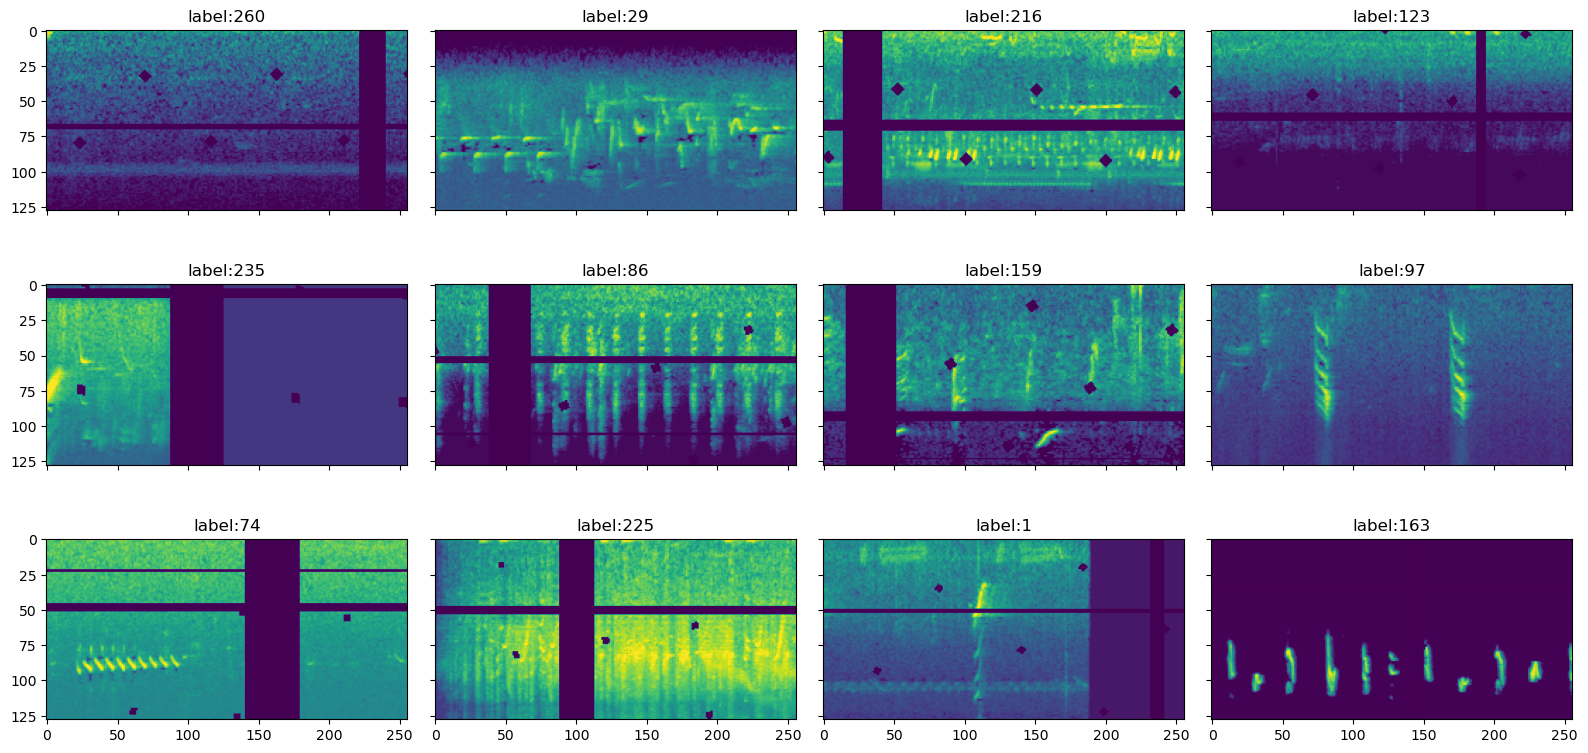

In [15]:
fig, axs = plt.subplots(3, 4, sharex='all', sharey='all', figsize=(16, 8))
for i, ax in enumerate(axs.flat):
    img = elem[0][i]
    show_img_stats(img)
    ax.imshow(img, cmap="viridis")
    ax.set_title(f"label:{np.argmax(elem[1][i].numpy())}")
plt.tight_layout()
plt.show()

# Neural network

In [16]:
from tensorflow.keras.applications.efficientnet import EfficientNetB0 as BaseModel
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras import layers, losses, metrics, callbacks

In [17]:
def create_model(lr):
    inputs = layers.Input(shape=cfg.img_shape, dtype=tf.float32)
    x = tf.image.grayscale_to_rgb(inputs)
    x = layers.Lambda(preprocess_input, name="preprocess_input")(x)
    base_model = BaseModel(include_top=False, weights=cfg.base_model_weights, pooling="avg")
    base_model.trainable = True
    fine_tune_at = 100  # Specify the number of layers to fine-tune
    for layer in base_model.layers[:-fine_tune_at]:
        layer.trainable = False
    x = base_model(x)
    #x = base_model(x, training=False)
    x = layers.Dropout(cfg.dropout, name="top_dropout")(x)
    outputs = layers.Dense(cfg.n_label, name="logits")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=cfg.model_name)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True, label_smoothing=cfg.label_smoothing),
        metrics=['acc']
    )
    return model

#### Check model

In [18]:
tf.keras.backend.clear_session()
with strategy.scope():
    dev_model = create_model(lr=cfg.lr)
dev_model.summary(line_length=120)

16705208/16705208 [==============================] - 1s 0us/step
Model: "transfer_learn_simple"
________________________________________________________________________________________________________________________
 Layer (type)                                         Output Shape                                    Param #           
 input_1 (InputLayer)                                 [(None, 128, 256, 1)]                           0                 
                                                                                                                        
 tf.image.grayscale_to_rgb (TFOpLambda)               (None, 128, 256, 3)                             0                 
                                                                                                                        
 preprocess_input (Lambda)                            (None, 128, 256, 3)                             0                 
                                                         

In [19]:
dev_model.predict(dev_ds.take(1))

1/1 [==============================] - 5s 5s/step


array([[ 0.13295831,  0.3590737 , -0.06809726, ...,  0.07299072,
         0.33196914, -0.66195786],
       [-0.08935425,  0.16011754,  0.36345148, ...,  1.0178213 ,
        -0.0843536 ,  0.05688484],
       [-0.5824128 ,  0.02316216,  0.50974023, ..., -0.86487275,
         0.15131861, -0.95303047],
       ...,
       [ 0.47590017,  0.02153075,  0.17819577, ...,  0.912055  ,
         0.05439451, -1.283573  ],
       [ 0.13283819, -0.28020054,  0.39959872, ...,  0.71315014,
         0.23865807, -0.09385121],
       [-0.29124382, -0.03313129,  0.45450428, ...,  0.18840945,
         0.16869582, -0.06167759]], dtype=float32)

In [20]:
dev_model.evaluate(dev_ds.take(1), return_dict=True)

1/1 [==============================] - 6s 6s/step - loss: 0.7155 - acc: 0.0078


{'loss': 0.7155226469039917, 'acc': 0.0078125}

# Training utils

In [21]:
def get_callbacks(filepath):
    """Get callbacks"""
    cbs = [
        callbacks.ModelCheckpoint(
            filepath=filepath,
            monitor=cfg.monitor,
            mode=cfg.monitor_mode,
            verbose=1,
            save_best_only=True,
            save_weights_only=True            
        ),
        callbacks.EarlyStopping(
            monitor=cfg.monitor,
            mode=cfg.monitor_mode,
            verbose=1,
            patience=cfg.patience,
            restore_best_weights=False,
        ),
    ]
    return cbs


def show_history(history):
    """Show history"""
    history_frame = pd.DataFrame(history.history)
    history_frame.index = pd.RangeIndex(1, len(history_frame) + 1, name="epoch")
    display(history_frame.style\
        .highlight_min(color='lightgreen', subset=['val_loss'])\
        .highlight_max(color='lightgreen', subset=['val_acc'])
    )
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))
    history_frame.loc[:, ['loss', 'val_loss']].plot(ax=ax[0], title='loss')
    history_frame.loc[:, ['acc', 'val_acc']].plot(ax=ax[1], title='acc')
    plt.tight_layout()
    plt.show()
    
    
def compute_oof(model, valid_df):
    """Compute OOF"""
    valid_ds = create_validation_dataset(valid_df)
    oof_pred = model.predict(valid_ds, verbose=False)
    oof_pred = pd.DataFrame(tf.nn.sigmoid(oof_pred).numpy(), index=valid_df.index)
    oof = pd.concat({"y_true": valid_df[cfg.label], "y_pred": oof_pred}, axis=1)
    return oof    

In [22]:
def run_training(train_df, valid_df, model_name):
    """Run training"""
    # prepare dataset
    train_ds = create_training_dataset(train_df)
    valid_ds = create_validation_dataset(valid_df)
    # create model
    tf.keras.backend.clear_session()
    with strategy.scope():
        model = create_model(lr=cfg.lr)
  #  model.load_weights("/kaggle/input/fine-tune-60/weights_dev-b0-v8.h5")
    # fit
    steps_per_epoch = cfg.steps_per_epoch
    print("steps_per_epoch:", steps_per_epoch)
    path_weight = f"/kaggle/working/weights_{model_name}.h5"
    print("path_weights:", path_weight)
    hist = model.fit(
        train_ds,
        epochs=cfg.epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=valid_ds,
        callbacks=get_callbacks(path_weight),
        verbose=cfg.fit_verbose
    )
    # restore
    model.load_weights(path_weight)
#     # save full model
#     does not work: https://github.com/keras-team/keras/pull/17498 
#     path_model = f"/kaggle/working/{model_name}"
#     print("path_model:", path_model)
#     model.save(path_model)
    # compute oof
    oof = compute_oof(model, valid_df)
    return hist, oof,model

# Run training
Let us start by training just a single split.

In [23]:
train_df, valid_df = train_test_split(data, test_size=cfg.test_size, stratify=data[cfg.label])
valid_df, test_df = train_test_split(valid_df, test_size=0.5, stratify=valid_df[cfg.label])
print(f"Split: {len(train_df)} vs {len(valid_df)} vs {len(test_df)}")
model_name = f"{cfg.model_name}"
print(f"model_name: {model_name}")

Split: 102812 vs 12851 vs 12852
model_name: transfer_learn_simple


In [24]:
hist, oof,model = run_training(train_df, valid_df, model_name)

steps_per_epoch: 300
path_weights: /kaggle/working/weights_transfer_learn_simple.h5
Epoch 1/80

Epoch 1: val_loss improved from inf to 0.13173, saving model to /kaggle/working/weights_transfer_learn_simple.h5
300/300 - 439s - loss: 0.2066 - acc: 0.0305 - val_loss: 0.1317 - val_acc: 0.0669 - 439s/epoch - 1s/step
Epoch 2/80

Epoch 2: val_loss improved from 0.13173 to 0.12939, saving model to /kaggle/working/weights_transfer_learn_simple.h5
300/300 - 354s - loss: 0.1305 - acc: 0.0657 - val_loss: 0.1294 - val_acc: 0.0913 - 354s/epoch - 1s/step
Epoch 3/80

Epoch 3: val_loss improved from 0.12939 to 0.12905, saving model to /kaggle/working/weights_transfer_learn_simple.h5
300/300 - 324s - loss: 0.1300 - acc: 0.0835 - val_loss: 0.1290 - val_acc: 0.1246 - 324s/epoch - 1s/step
Epoch 4/80

Epoch 4: val_loss improved from 0.12905 to 0.12848, saving model to /kaggle/working/weights_transfer_learn_simple.h5
300/300 - 225s - loss: 0.1296 - acc: 0.1126 - val_loss: 0.1285 - val_acc: 0.1650 - 225s/epoc

,loss,acc,val_loss,val_acc
epoch,,,,
1,0.206587,0.030547,0.131726,0.066921
2,0.130498,0.065703,0.129389,0.091277
3,0.130004,0.083490,0.129046,0.124582
4,0.129641,0.112604,0.128483,0.165046
5,0.129207,0.144141,0.128021,0.201696
6,0.128767,0.179557,0.127597,0.232433
7,0.128378,0.213047,0.127214,0.266905
8,0.127982,0.244818,0.126805,0.300833
9,0.127601,0.279948,0.126485,0.334838


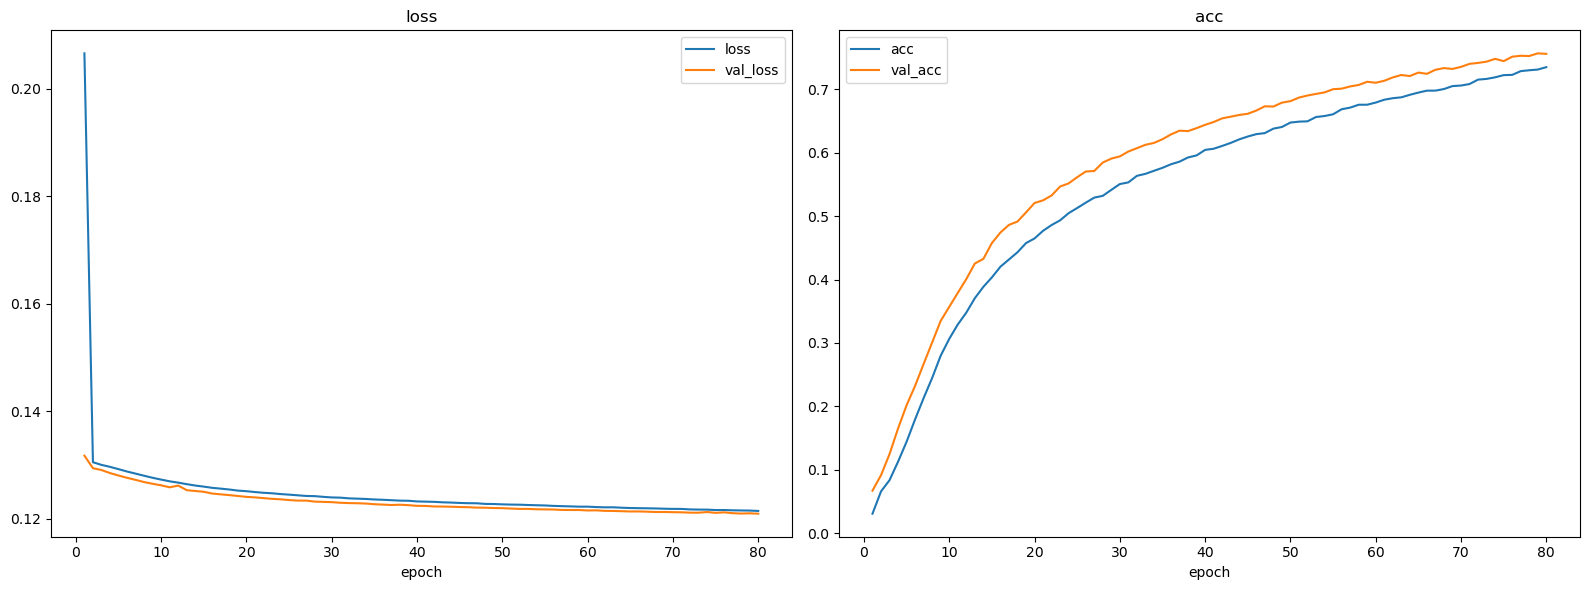

In [25]:
show_history(hist)

In [26]:
oof.to_csv("oof.csv")

# Evaluation

In [27]:
test_ds = create_validation_dataset(test_df)

In [28]:
true_labels = []
i=0
test_ds_size = test_ds.cardinality().numpy()
print(test_ds_size)
for batch in test_ds:
    _, batch_labels = batch  # assuming that labels are the second element of the batch tuple
    true_labels.extend(batch_labels.numpy().tolist())
    i+=1

101


In [29]:
pred_labels = model.predict(test_ds, verbose=cfg.fit_verbose, workers=os.cpu_count(), use_multiprocessing=True)

101/101 - 10s - 10s/epoch - 98ms/step


In [30]:
from sklearn.metrics import average_precision_score
mAP_score = average_precision_score(true_labels, pred_labels, average='macro')
print(mAP_score)

0.6719930328633623


In [31]:
from sklearn.metrics import accuracy_score
true_label = np.array(true_labels)
true_label = np.argmax(true_labels, axis=1)

pred_label=tf.argmax(pred_labels, axis=1).numpy()
# # assume y_true and y_pred are your true and predicted labels, respectively
acc = accuracy_score(true_label, pred_label)
print(acc)

0.7500778089013383
